In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import os
import errno

import numpy as np

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.optimizers import Adam

from deepcell import make_training_data
from deepcell.model_zoo import bn_feature_net_3D
from deepcell.model_zoo import disc_net_3D
from deepcell.training import train_model_movie, train_model_disc_3D
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler

In [2]:
# data options
DATA_OUTPUT_MODE = 'conv'
BORDER_MODE = 'valid' if DATA_OUTPUT_MODE == 'sample' else 'same'
RESIZE = True
RESHAPE_SIZE = 256
NUM_FRAMES = 30 # get first N frames from each training folder

# filepath constants
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'
PREFIX = 'cells/MouseBrain/generic'
DATA_FILE = 'MouseBrain_{}_{}'.format(K.image_data_format(), DATA_OUTPUT_MODE)

for d in (NPZ_DIR, MODEL_DIR, RESULTS_DIR):
    try:
        os.makedirs(os.path.join(d, PREFIX))
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

In [8]:
# Generate training data
file_name_save = os.path.join(NPZ_DIR, PREFIX, DATA_FILE)
num_of_features = 2  # Specify the number of feature masks that are present
window_size = (30, 30)  # Size of window around pixel
training_direcs = ['set6']
channel_names = ['slice']
raw_image_direc = 'stacked_raw'
annotation_direc = 'annotated/all_montages'

# Create the training data
make_training_data(
    direc_name=os.path.join(DATA_DIR, PREFIX),
    dimensionality=3,
    window_size_x=window_size[0],
    window_size_y=window_size[1],
    border_mode=BORDER_MODE,
    file_name_save=file_name_save,
    training_direcs=training_direcs,
    channel_names=channel_names,
    num_frames=NUM_FRAMES,
    num_of_frames_to_display=5,
    num_of_features=num_of_features,
    montage_mode=True,
    raw_image_direc=raw_image_direc,
    annotation_direc=annotation_direc,
    annotation_name='',  # basically channel name but for annotated images
    reshape_size=RESHAPE_SIZE if RESIZE else None,
    edge_feature=[1, 0, 0], # Specify which feature is the edge feature,
    dilation_radius=1,
    output_mode=DATA_OUTPUT_MODE,
    display=False,
    process=True,
    process_std=True,
    verbose=True)

Loading slice channel data from training dir 1: /data/data/cells/MouseBrain/generic/set6/stacked_raw/set_6_x_0_y_0
Skipping final 11 frames, as num_frames is 30 but there are 41 total frames
Loading slice channel data from training dir 2: /data/data/cells/MouseBrain/generic/set6/stacked_raw/set_6_x_0_y_1
Skipping final 11 frames, as num_frames is 30 but there are 41 total frames
Loading slice channel data from training dir 3: /data/data/cells/MouseBrain/generic/set6/stacked_raw/set_6_x_0_y_2
Skipping final 11 frames, as num_frames is 30 but there are 41 total frames
Loading slice channel data from training dir 4: /data/data/cells/MouseBrain/generic/set6/stacked_raw/set_6_x_0_y_3
Skipping final 11 frames, as num_frames is 30 but there are 41 total frames
Loading slice channel data from training dir 5: /data/data/cells/MouseBrain/generic/set6/stacked_raw/set_6_x_1_y_0
Skipping final 11 frames, as num_frames is 30 but there are 41 total frames
Loading slice channel data from training dir 

In [3]:
# Foreground/background model
direc_save = os.path.join(MODEL_DIR, PREFIX)
direc_data = os.path.join(NPZ_DIR, PREFIX)
training_data = np.load(os.path.join(direc_data, DATA_FILE + '.npz'))

X, y = training_data['X'], training_data['y']

n_epoch = 10
batch_size = 1
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
lr_sched = rate_scheduler(lr=0.0001, decay=0.99)
frames_per_batch = 10

is_channels_first = K.image_data_format() == 'channels_first'
row_axis = 3 if is_channels_first else 2
col_axis = 4 if is_channels_first else 3
channel_axis = 1 if is_channels_first else 4

size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X.shape[row_axis:col_axis + 1]
if is_channels_first:
    batch_shape = (batch_size, X.shape[channel_axis], frames_per_batch, size[0], size[1])
else:
    batch_shape = (batch_size, frames_per_batch, size[0], size[1], X.shape[channel_axis])

fgbg_model = bn_feature_net_3D(
    batch_shape=batch_shape,
    n_features=2,
    location=False,
    norm_method='whole_image')

train_model_movie(
    model=fgbg_model,
    dataset=DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    number_of_frames=frames_per_batch,
    n_epoch=n_epoch,
    direc_save=direc_save,
    direc_data=direc_data,
    lr_sched=lr_sched,
    expt='fgbg',
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (14, 30, 256, 256, 1)
y_train shape: (14, 30, 256, 256, 1)
X_test shape: (2, 30, 256, 256, 1)
y_test shape: (2, 30, 256, 256, 1)
Output Shape: (1, 10, 256, 256, 2)
Number of Classes: 2
Using real-time data augmentation.
Epoch 1/10
41/42 [============================>.] - ETA: 1s - loss: 0.2606 - acc: 0.9091
Epoch 00001: val_loss improved from inf to 0.27752, saving model to /data/models/cells/MouseBrain/generic/2018-08-15_MouseBrain_channels_last_conv_fgbg_0.h5
42/42 [==============================] - 1145s 27s/step - loss: 0.2601 - acc: 0.9094 - val_loss: 0.2775 - val_acc: 0.9469
Epoch 2/10
41/42 [============================>.] - ETA: 1s - loss: 0.1617 - acc: 0.9272
Epoch 00002: val_loss improved from 0.27752 to 0.20981, saving model to /data/models/cells/MouseBrain/generic/2018-08-15_MouseBrain_channels_last_conv_fgbg_0.h5
42/42 [==============================] - 170s 4s/step - loss: 0.1604 - acc: 0.9277 - val_loss: 0.2098 - val_acc: 0.9605
Epoch 3/10
41/42 [=========

In [4]:
# Disc model
direc_save = os.path.join(MODEL_DIR, PREFIX)
direc_data = os.path.join(NPZ_DIR, PREFIX)
training_data = np.load(os.path.join(direc_data, DATA_FILE + '.npz'))

X, y = training_data['X'], training_data['y']

n_epoch = 20
batch_size = 32 if DATA_OUTPUT_MODE == 'sample' else 1
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
lr_sched = rate_scheduler(lr=0.0001, decay=0.99)
frames_per_batch = 10

is_channels_first = K.image_data_format() == 'channels_first'
row_axis = 3 if is_channels_first else 2
col_axis = 4 if is_channels_first else 3
channel_axis = 1 if is_channels_first else 4

size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X.shape[row_axis:col_axis + 1]
if is_channels_first:
    batch_shape = (batch_size, X.shape[channel_axis], frames_per_batch, size[0], size[1])
else:
    batch_shape = (batch_size, frames_per_batch, size[0], size[1], X.shape[channel_axis])

disc_model = disc_net_3D(
    batch_shape=batch_shape,
    norm_method='whole_image',
    n_features=3, # Embedding dimensions
    location=True,
    seg_model=fgbg_model,
    softmax=False)

train_model_disc_3D(
    model=disc_model,
    dataset=DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    direc_save=direc_save,
    direc_data=direc_data,
    lr_sched=lr_sched,
    number_of_frames=10,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=0) # a float or a tuple or list of two floats

X_train shape: (14, 30, 256, 256, 1)
y_train shape: (14, 30, 256, 256, 1)
X_test shape: (2, 30, 256, 256, 1)
y_test shape: (2, 30, 256, 256, 1)
Output Shape: (1, 10, 256, 256, 3)
Number of Classes: 3
Epoch 1/20
41/42 [============================>.] - ETA: 5s - loss: 5.5498 
Epoch 00001: val_loss improved from inf to 6.98708, saving model to /data/models/cells/MouseBrain/generic/2018-08-15_MouseBrain_channels_last_conv__0.h5
42/42 [==============================] - 271s 6s/step - loss: 5.5517 - val_loss: 6.9871
Epoch 2/20
41/42 [============================>.] - ETA: 4s - loss: 5.0654
Epoch 00002: val_loss improved from 6.98708 to 6.20153, saving model to /data/models/cells/MouseBrain/generic/2018-08-15_MouseBrain_channels_last_conv__0.h5
42/42 [==============================] - 528s 13s/step - loss: 5.0656 - val_loss: 6.2015
Epoch 3/20
41/42 [============================>.] - ETA: 4s - loss: 5.0556
Epoch 00003: val_loss improved from 6.20153 to 5.28312, saving model to /data/models/ce

In [5]:
training_data_file_name = os.path.join(direc_data, DATA_FILE + '.npz')
train_dict, (X_test, y_test) = get_data(training_data_file_name, mode='conv', seed=21)

test_images = disc_model.predict(X_test[:1,:10,:,:,:])
test_images_fgbg = fgbg_model.predict(X_test[:1,:10,:,:,:])

print(test_images.shape)
print(test_images_fgbg.shape)

(1, 10, 256, 256, 3)
(1, 10, 256, 256, 2)


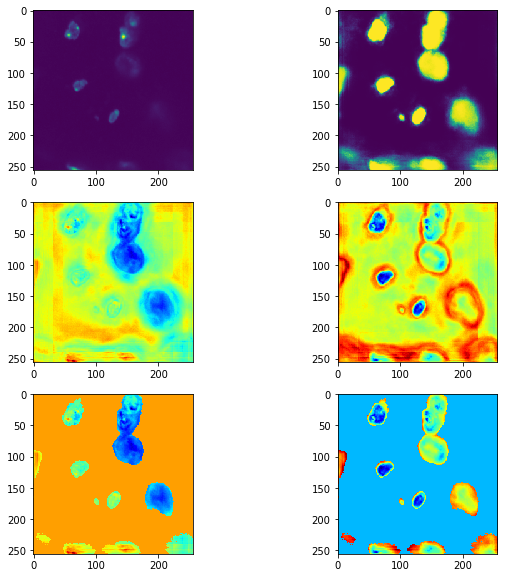

In [6]:
import matplotlib.pyplot as plt

channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

plt.rcParams['figure.figsize'] = [10, 10]

fg_thresh = test_images_fgbg[:, :, :, :, 1] > 0.5
fg_thresh = np.expand_dims(fg_thresh, axis=channel_axis)
test_images_post_fgbg=test_images[:, :, :, :, :] * fg_thresh

index = 2

plt.subplot(3, 2, 1)
plt.imshow(X_test[0, index, :, :, 0])

plt.subplot(3, 2, 2)
plt.imshow(test_images_fgbg[0, index, :, :, 1])

plt.subplot(3, 2, 3)
plt.imshow(test_images[0, index, :, :, 0], cmap='jet')

plt.subplot(3, 2, 4)
plt.imshow(test_images[0, index, :, :, 1], cmap='jet')

plt.subplot(3, 2, 5)
plt.imshow(test_images_post_fgbg[0, index, :, :, 0], cmap='jet')

plt.subplot(3, 2, 6)
plt.imshow(test_images_post_fgbg[0, index, :, :, 1], cmap='jet')

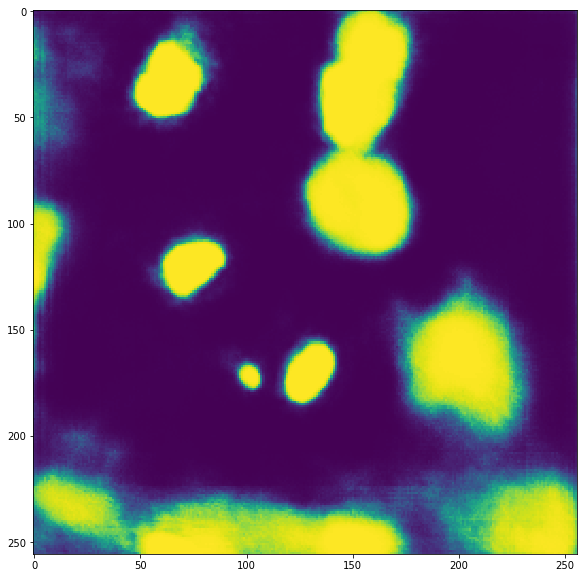

In [7]:
import matplotlib.pyplot as plt

channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

plt.rcParams['figure.figsize'] = [10, 10]

training_data_file_name = os.path.join(direc_data, DATA_FILE + '.npz')
train_dict, (X_test, y_test) = get_data(training_data_file_name, mode='conv', seed=21)
test_images_fgbg = fgbg_model.predict(X_test[:1,:10,:,:,:])

plt.imshow(test_images_fgbg[0, 0, :, :, 1])


MeanShift - number of estimated clusters : 11


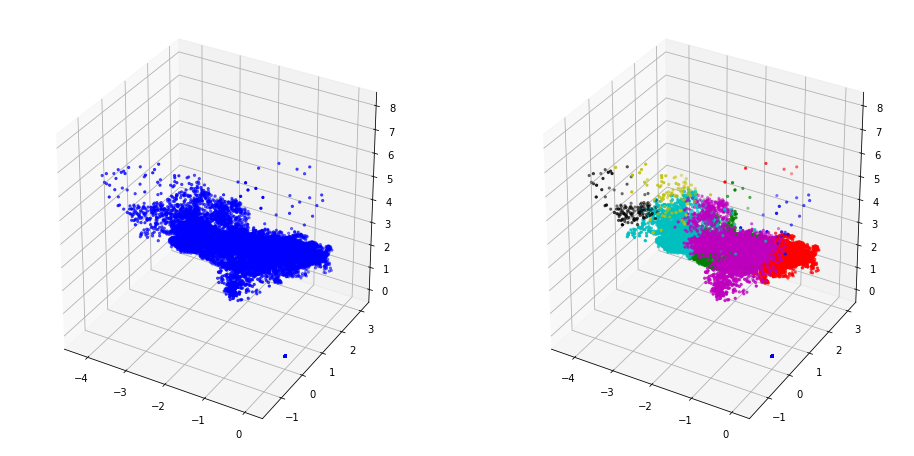

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

plt.rcParams['figure.figsize'] = [16, 8]

fg_thresh = test_images_fgbg[:, :, :, :, 1] > 0.6
fg_thresh = np.expand_dims(fg_thresh, axis=channel_axis)
test_images_post_fgbg=test_images[:, :, :, :, :] * fg_thresh

index = 0

# Mean Shift
from sklearn.cluster import MeanShift, estimate_bandwidth

test_plot = test_images_post_fgbg[index, 0, :, :, :].reshape(-1, 3)
bandwidth = estimate_bandwidth(test_plot, n_samples=2000)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(test_plot)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
test_plot_mean_shift = labels.reshape(256, 256)

print("MeanShift - number of estimated clusters : %d" % n_clusters_)

# Original
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.scatter(test_plot[:, 0], test_plot[:, 1], test_plot[:, 2], c='b', marker='o', s=5)

# Scatter plot after MeanShift 
from itertools import cycle

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
ax = fig.add_subplot(122, projection='3d')

for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    ax.scatter(test_plot[my_members, 0], test_plot[my_members, 1], test_plot[my_members, 2], c=col, s=5)


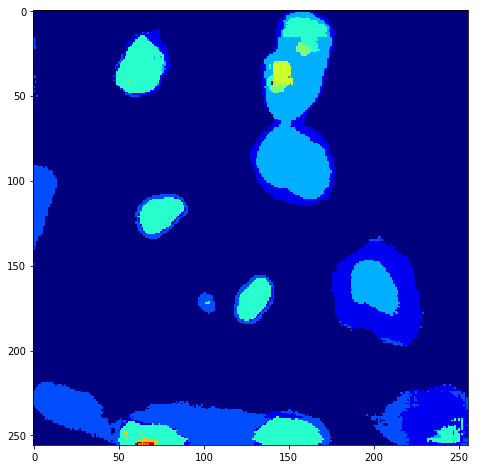

In [9]:
plt.imshow(test_plot_mean_shift, cmap='jet')

In [10]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def get_js_video(images, batch=0, channel=0):
   fig = plt.figure()

   ims = []
   for i in range(images.shape[1]):
       im = plt.imshow(images[batch, i, :, :, channel], animated=True, cmap='jet')
       ims.append([im])

   ani = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1000)
   return HTML(ani.to_jshtml())

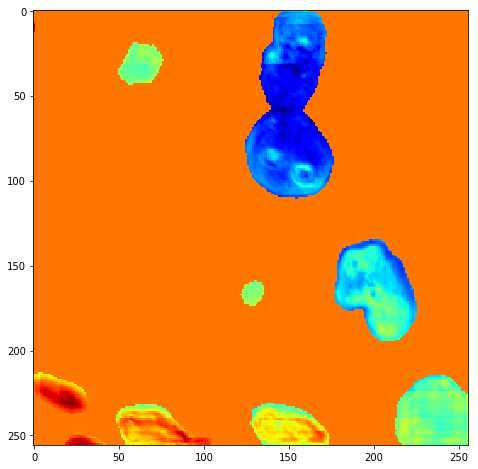

In [12]:
get_js_video(test_images_post_fgbg)